In [ ]:
pip install 'import_ipynb'

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=110a89f102c3ea3bcc1d7e0d7a2da3bfb33e55ef28a102fc41ab86309d227987
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import Image
import torchvision
import math
from sklearn.preprocessing import normalize
import copy
from scipy.special import softmax

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import random
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix as s_cm
from google.colab import drive
drive.mount('/content/drive')
  
%cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
 
import import_ipynb
from cifar100 import cifar_100
from net import resnet32

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
importing Jupyter notebook from cifar100.ipynb
IMPORT CIFAR DONE Rseed
importing Jupyter notebook from net.ipynb
IMPORT NET DONE


iCarl Model

In [ ]:
class iCaRLNet(nn.Module):
    def __init__(self, feature_size, n_classes, lr=2.0, momentum=0.9,gamma=0.2, weight_decay=1e-5, milestone=[49, 63], batch_size=128, num_epochs=70):
        # Network architecture
        super(iCaRLNet, self).__init__()
        self.net = resnet32(num_classes=n_classes)
        self.feature_extractor = self.net.get_fm_out #Modified
        self.lr = lr
        self.gamma = gamma
        self.momentum=momentum
        self.weight_decay = weight_decay
        self.milestone = milestone
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.n_classes = 0
        self.n_known = 0

        self.exemplar_sets = []
        self.feature_size=feature_size

        # Learning method
        self.BCEwithL = nn.BCEWithLogitsLoss()

        self.compute_means = True
        self.exemplar_means = []

        self.compute_SVM = True
        self.SVM=None
        self.compute_feat = True
        self.exemplar_feat = []
        self.exemplar_lab = []
        self.mapper = None


    def forward(self, x):
        self.net = self.net.cuda()
        return self.net.forward(x)
                                    

    def compute_precisions(self,y_true, y_pred, last_classes):
        precisions = []
        for c in last_classes:
            correct = sum(y_pred[y_true == c] == c)
            wrong = sum(y_pred[y_true == c] != c)
            tot = correct + wrong
            prec = correct / tot
            precisions.append(prec)
        return softmax(precisions)
        

    def classify(self, x, cif):  
        if self.compute_means:
            print("Computing mean of exemplars...")
            exemplar_means = []
            for P_y in self.exemplar_sets:  #P_y list of indices
                features = np.zeros((0,64))
                sub = Subset(cif, P_y)
                dl = torch.utils.data.DataLoader(sub, batch_size=self.batch_size,shuffle=False, num_workers=4)
                # Extract feature for each exemplar in P_y
                with torch.no_grad():
                  for ind, ex, lab in dl:
                    ex = Variable(ex).cuda()
                    feature = self.feature_extractor(ex).data.cpu().numpy()
                    feature = normalize(feature, axis=1, norm='l2')
                    features = np.concatenate((features,feature), axis=0)

                features = torch.tensor(features)
                mu_y = features.mean(0).squeeze()
                mu_y.data = mu_y.data / torch.norm(mu_y, p=2)  # L2 Normalize
                exemplar_means.append(mu_y)

            self.exemplar_means = exemplar_means
            self.compute_means = False
            print("Done")

        exemplar_means = self.exemplar_means
        means = torch.stack(exemplar_means)  # (n_classes, feature_size)
        means = torch.stack([means] * self.batch_size)  # (batch_size, n_classes, feature_size)
        means = means.transpose(1, 2)  # (batch_size, feature_size, n_classes)

        feature = self.feature_extractor(x)  # (batch_size, feature_size)
        for i in range(feature.size(0)):  # Normalize
            feature.data[i] = feature.data[i] / torch.norm(feature.data[i], p=2)
        feature = feature.unsqueeze(2)  # (batch_size, feature_size, 1)
        feature = feature.expand_as(means)  # (batch_size, feature_size, n_classes)
        feature = feature.cuda()
        means = means.cuda()

        dists = torch.sqrt((feature - means).pow(2).sum(1)).squeeze()  # (batch_size, n_classes)
        _, preds = dists.min(1) 

        return preds


    def classify_Cermelli(self, x, cif, rl): 
        if self.compute_means:
            exemplar_means = []
            for i,P_y in enumerate(self.exemplar_sets):  #P_y list of indice
                
                features = np.zeros((0,self.feature_size))
                if i<self.n_classes-10:
                    #print("VECCHIE CLASSI")
                    sub = Subset(cif, P_y)
                    #print(len(sub))
                    dl = torch.utils.data.DataLoader(sub, batch_size=self.batch_size,shuffle=False, num_workers=4) 
                    with torch.no_grad():
                        for ind, ex, lab in dl:# Extract feature for each exemplar in P_y
                            ex = Variable(ex).cuda()
                            feature = self.feature_extractor(ex).data.cpu().numpy()
                            feature = normalize(feature, axis=1, norm='l2')
                            features = np.concatenate((features,feature), axis=0)
                else:
                    #print("NUOVE CLASSI")
                    indexes=cif.getClassIndexes(rl[i])
                    sub = Subset(cif, indexes)
                    #print(len(sub))
                    dl = torch.utils.data.DataLoader(sub, batch_size=self.batch_size,shuffle=False, num_workers=4) 
                    with torch.no_grad():
                        for ind, ex, lab in dl:# Extract feature for each exemplar in P_y
                            ex = Variable(ex).cuda()
                            feature = self.feature_extractor(ex).data.cpu().numpy()
                            feature = normalize(feature, axis=1, norm='l2')
                            features = np.concatenate((features,feature), axis=0)

                features = torch.tensor(features)
                mu_y = features.mean(0).squeeze()
                mu_y.data = mu_y.data / torch.norm(mu_y, p=2)  # L2 Normalize
                exemplar_means.append(mu_y)
                
            self.exemplar_means = exemplar_means
            self.compute_means = False

        exemplar_means = self.exemplar_means
        means = torch.stack(exemplar_means)  # (n_classes, feature_size)
        means = torch.stack([means] * self.batch_size)  # (batch_size, n_classes, feature_size)
        means = means.transpose(1, 2)  # (batch_size, feature_size, n_classes)

        feature = self.feature_extractor(x)  # (batch_size, feature_size)
        for i in range(feature.size(0)):  # Normalize
            feature.data[i] = feature.data[i] / torch.norm(feature.data[i], p=2)
        feature = feature.unsqueeze(2)  # (batch_size, feature_size, 1)
        feature = feature.expand_as(means)  # (batch_size, feature_size, n_classes)
        feature = feature.cuda()
        means = means.cuda()

        dists = torch.sqrt((feature - means).pow(2).sum(1)).squeeze()  # (batch_size, n_classes)
        _, preds = dists.min(1)

        return preds


    def compute_exemplar_features(self, cif, mapper):
        if self.compute_feat:
            exemplar_feat = np.zeros((0,self.feature_size))
            labs=[]
            for exemplar_list in self.exemplar_sets:  #exemplar_list list of exemplar indexes
                features = np.zeros((0,self.feature_size))
                sub = Subset(cif, exemplar_list)
                dl = torch.utils.data.DataLoader(sub, batch_size=self.batch_size,shuffle=False, num_workers=4) 

                with torch.no_grad():
                    for ind, ex, lab in dl:# Extract feature for each exemplar in exemplar_list
                        ex = Variable(ex).cuda()
                        lab = [mapper[l.item()] for l in lab]
                        feature = self.feature_extractor(ex).data.cpu().numpy() #(batch_size, feature_size)
                        feature = normalize(feature, axis=1, norm='l2')
                        features = np.concatenate((features,feature), axis=0)
                        labs.extend(lab)
                        
                exemplar_feat=np.concatenate((exemplar_feat,features), axis=0)

            self.exemplar_lab=labs
            self.exemplar_feat = exemplar_feat
            self.compute_feat = False

    
    def classify_SVM(self, x): 
        if self.compute_SVM:
            #TRAIN
            x_train = self.exemplar_feat
            y_train = self.exemplar_lab
            c = 1 
            rbf = SVC(kernel='rbf', C=c)
            rbf.fit(x_train, y_train)
            self.SVM = rbf
            self.compute_SVM = False
        #TEST
        feature = self.feature_extractor(x)  # (batch_size, feature_size)
        for i in range(feature.size(0)):  # Normalize
            feature.data[i] = feature.data[i] / torch.norm(feature.data[i], p=2)
        x_test=feature.detach().cpu().numpy()
        y_pred=self.SVM.predict(x_test)
        y_pred=torch.Tensor(y_pred)
        return y_pred



    def construct_exemplar_set(self, images, m):
   
        # Compute and cache features for each example
        features = np.zeros((0,64))
        indices = np.zeros((0), dtype=int)
        dl = torch.utils.data.DataLoader(images, batch_size=self.batch_size,shuffle=False, num_workers=4)
        with torch.no_grad():
          for ind, img, lab in dl:
            x = Variable(img).cuda()
            feature = self.feature_extractor(x).data.cpu().numpy()
            feature = normalize(feature, axis=1, norm='l2')
            features = np.concatenate((features,feature), axis=0)
            indices = np.concatenate((indices,ind), axis=0)

        class_mean = np.mean(features, axis=0)
        class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize

        exemplar_set = []
        exemplar_features = np.zeros((0,64))

        for k in range(1, int(m)+1):
            S = np.sum(exemplar_features, axis=0)
            phi = features
            mu = class_mean
            mu_p = 1.0 / k * (phi + S)
            mu_p = normalize(mu_p, axis=1, norm='l2')
            i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
            exemplar_set.append(indices[i])
            addfeature =  np.expand_dims(features[i], axis=0)
            exemplar_features = np.concatenate((exemplar_features,addfeature), axis=0)

            #remove duplicates
            features = np.delete(features, i, 0)
            indices = np.delete(indices, i, 0)

        self.exemplar_sets.append(exemplar_set)
    

    def reduce_exemplar_sets(self, prop):
        len_e=[]
        for y, P_y in enumerate(self.exemplar_sets):
            l=prop*len(P_y)
            if l>int(l)+0.5:
                l=l+1
            self.exemplar_sets[y] = P_y[:int(l)]
            len_e.append(len(self.exemplar_sets[y]))

    
    def delete_last10_exemplar(self):
        self.exemplar_sets=self.exemplar_sets[:len(self.exemplar_sets)-10]
    

    def combine_dataset_with_exemplars(self, cifar):
        newindexes = []
        for y, P_y in enumerate(self.exemplar_sets):
            exemplar_images = P_y
            exemplar_labels = [y] * len(P_y)
            print(exemplar_images[0].shape)
            newindexes+=cifar.data_append(exemplar_images, exemplar_labels)
        return newindexes

    def exemplarIndexes(self):
      Indexes = []
      for P_y in self.exemplar_sets:
        Indexes += P_y
      return Indexes


    def update_representation(self, cifar, batchindexes, diz):
        prev_model = copy.deepcopy(self)
        prev_model = prev_model.eval().cuda()
        self.compute_means = True
        self.compute_SVM = True
        self.compute_feat = True

        self.n_classes += 10
        print("%d new classes" % (10))
        print(len(batchindexes))
        # Form combined training set
        newindexes = []
        if self.n_classes > 10:
          newindexes = self.exemplarIndexes()
        newindexes += list(batchindexes)
        print(len(newindexes))
        reprdata = Subset(cifar, newindexes)

        loader = torch.utils.data.DataLoader(reprdata, batch_size=self.batch_size,shuffle=True, num_workers=4, drop_last=True)

        # Run network training

        optimizer = optim.SGD(self.net.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestone, gamma=self.gamma)

        print("TRAIN")
        for epoch in range(self.num_epochs):
            losses = []
            classlosses = []
            distlosses = []
            for indices, images, labels in loader:
                labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
                images = Variable(torch.FloatTensor(images)).cuda()
                labels = Variable(labels).cuda()
                optimizer.zero_grad()
                g = self.forward(images)
                y_hot = F.one_hot(labels, self.n_classes).float().cuda()
                ClassScalefactor = ((10)/(self.n_classes))
                loss = self.BCEwithL(g[:,self.n_known:self.n_classes], y_hot[:,self.n_known:self.n_classes])*ClassScalefactor
            
                if self.n_known > 0:
                    GammaFactor = 1 - (self.n_classes/(self.n_known+self.n_classes))
                    GammaFactor = math.exp(-GammaFactor)
                    adjustment = loss * GammaFactor
                    loss = loss+adjustment
                    classlosses.append(loss.item())
                    q = prev_model.forward(images)
                    q = torch.sigmoid(q)
                    distScaleFactor = (self.n_known)/(self.n_classes)
                    distloss = self.BCEwithL(g[:,:self.n_known], q[:,:self.n_known]) * distScaleFactor 
                    distlosses.append(distloss.item())
                    loss += distloss
                else:
                    classlosses.append(loss.item())
                losses.append(loss.item())
                loss.backward()
                optimizer.step()

            if (epoch + 1) % 5 == 0:
                if len(distlosses) == 0:
                    mean_dist = 0
                else:
                    mean_dist = np.mean(np.array(distlosses))
                print('Epoch [%d/%d], Average_Loss(tot, dist, class): %.4f, %.4f, %.4f' \
                  % (epoch + 1, self.num_epochs, np.mean(np.array(losses)), mean_dist, np.mean(np.array(classlosses))))

            scheduler.step()

    def set_mapper(self, mapper):
        self.mapper = mapper

    def get_mapper(self):
        if self.mapper is None:
            print("ERROR: mapper has not been set. Use model.set_mapper(mapper) first.")
            return None
        return self.mapper

    def compute_confusion_matrix(self, cif, title, plot=False, svm=False):
      
        cifar_test = cifar_100(100, 'test')
        dl = torch.utils.data.DataLoader(cifar_test, batch_size=128,shuffle=True, num_workers=4, drop_last=True)
        y_true = []
        y_pred = []
        for _, images, labels in dl:
            images = Variable(images).cuda()
            y_true.extend(labels)
            if not svm:
              y_pred_tmp = self.classify(images, cif)
            else:
              y_pred_tmp = self.classify_SVM(images)
            y_pred_tmp = [p.item() for p in y_pred_tmp]
            y_pred.extend(y_pred_tmp)
        
        y_true = [self.mapper[l.item()] for l in y_true]
        acc_matrix = s_cm(y_true, y_pred)

        if plot:
            plt.figure(figsize=(11,11))
            df_cm = pd.DataFrame(acc_matrix)
            sn.heatmap(df_cm, square=True, xticklabels=20, yticklabels=20)
            plt.title(title)
            plt.show()

        return acc_matrix


In [ ]:
total_classes = 100
num_classes = 10
random_seed = 981
cifarTrain = cifar_100(num_classes, 'train',  rand_seed=random_seed)
cifarTest = cifar_100(num_classes, 'test', rand_seed=random_seed)
randomlist = cifarTrain.get_classes_list()
diz = cifarTrain.get_dictionary()
def compute_acc(dl, model, mapper, rl):
    total = 0.0
    correct = 0.0
    correct_svm=0.0
    for _, images, labels in dl:
        labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
        images = Variable(images).cuda()
        preds = model.classify_Cermelli(images, cifarTrain,rl)
        preds_svm=model.classify_SVM(images) 
        total = total + len(labels)
        correct += (preds.data.cpu() == labels).sum()
        correct_svm += (preds_svm.data.cpu() == labels).sum()
        
    acc = 100 * correct / total
    acc_svm = 100 * correct_svm / total
    return acc, acc_svm

Files already downloaded and verified
Files already downloaded and verified


Main



Loading training examples for classes [28, 7, 17, 45, 46, 91, 63, 13, 95, 59]
Batch size: 5000
10 new classes
5000
5000
TRAIN
Epoch [5/70], Average_Loss(tot, dist, class): 0.3182, 0.0000, 0.3182
Epoch [10/70], Average_Loss(tot, dist, class): 0.2849, 0.0000, 0.2849
Epoch [15/70], Average_Loss(tot, dist, class): 0.2529, 0.0000, 0.2529
Epoch [20/70], Average_Loss(tot, dist, class): 0.2243, 0.0000, 0.2243
Epoch [25/70], Average_Loss(tot, dist, class): 0.2012, 0.0000, 0.2012
Epoch [30/70], Average_Loss(tot, dist, class): 0.1805, 0.0000, 0.1805
Epoch [35/70], Average_Loss(tot, dist, class): 0.1591, 0.0000, 0.1591
Epoch [40/70], Average_Loss(tot, dist, class): 0.1372, 0.0000, 0.1372
Epoch [45/70], Average_Loss(tot, dist, class): 0.1230, 0.0000, 0.1230
Epoch [50/70], Average_Loss(tot, dist, class): 0.0929, 0.0000, 0.0929
Epoch [55/70], Average_Loss(tot, dist, class): 0.0711, 0.0000, 0.0711
Epoch [60/70], Average_Loss(tot, dist, class): 0.0615, 0.0000, 0.0615
Epoch [65/70], Average_Loss(tot, 

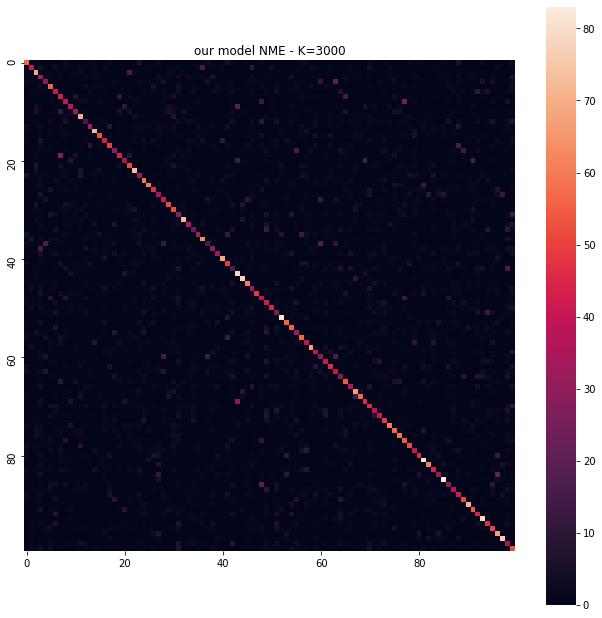

Files already downloaded and verified


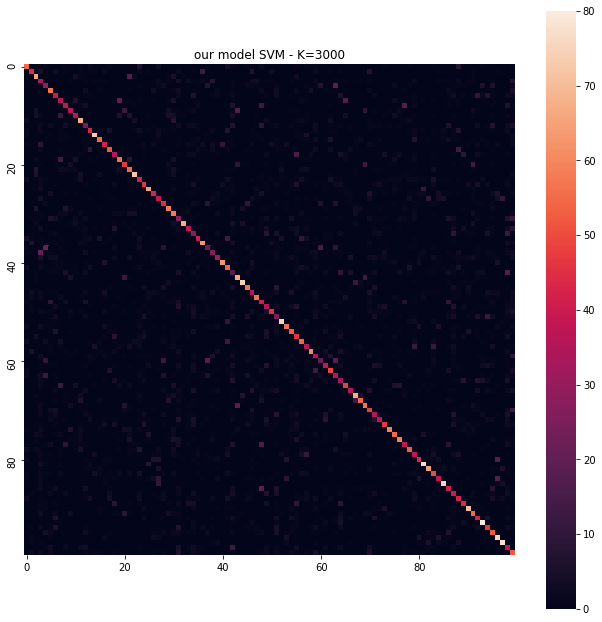

In [ ]:
torch.cuda.current_device()
torch.cuda._initialized = True
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize CNN
K = 3000  # total number of exemplars
icarl = iCaRLNet(64, 100, num_epochs=70)
icarl = icarl.to(DEVICE)
BATCH_SIZE = 128
acc_vect = []
icarl.set_mapper(diz)

for s in range(10):
    # Load Datasets
    print("\n\nLoading training examples for classes", randomlist[s*num_classes:s*num_classes + num_classes])
    batchindexes = cifarTrain.getClassIndexes(randomlist[s*num_classes:s*num_classes + num_classes])
    batch = Subset(cifarTrain, batchindexes)

    print("Batch size: {}".format(len(batch)))
    testindexes = cifarTest.getClassIndexes(randomlist[0:s*num_classes + num_classes])
    test_set = Subset(cifarTest, testindexes)

    train_loader = torch.utils.data.DataLoader(batch, batch_size=BATCH_SIZE,shuffle=True, num_workers=4, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle=False, num_workers=4, drop_last=True)

    # Update representation via BackProp
    icarl.train()
    icarl.update_representation(cifarTrain, batchindexes, diz)
    icarl.eval()

    m = K / icarl.n_classes

    # VETTORE DI M
    # FARLA IN PERCENTUALE
    icarl.reduce_exemplar_sets(s/(s+1))

    el_ex={}
    tot_len=0
    for z,el in enumerate(icarl.exemplar_sets):
        el_ex[z]=len(el)
        tot_len+=len(el)
    print(f"Total_len exemplars old classes:{tot_len}")
    #if tot_len:
        #print(el_ex)

    
    sum_m_old=0
    # Construct exemplar sets for new classes
    for y in randomlist[s*num_classes:s*num_classes + num_classes]:
        #print("Constructing exemplar set for class-%d..." % (y))
        imagesInd = cifarTrain.getClassIndexes([y])
        images = Subset(cifarTrain, imagesInd)
        # print(imagesInd)
        icarl.construct_exemplar_set(images, m)
        sum_m_old+=m
        #print("Done exemplars")

    icarl.n_known = icarl.n_classes
    icarl.compute_exemplar_features(cifarTrain, diz)

    print("iCaRL classes: %d" % icarl.n_known)

    total = 0.0
    correct = 0.0
    correct_svm=0.0
    for indices, images, labels in train_loader:
        labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
        images = Variable(images).cuda()
        preds = icarl.classify_Cermelli(images, cifarTrain, randomlist)
        preds_svm=icarl.classify_SVM(images) 
        total = total + len(labels)
        correct += (preds.data.cpu() == labels).sum()
        correct_svm += (preds_svm.data.cpu() == labels).sum()
    acc = 100 * correct / total
    acc_svm = 100 * correct_svm / total
    print('Train Accuracy: {:.2f}, SVM Accuracy: {:.2f}'.format(acc, acc_svm).rstrip())

    total = 0.0
    correct = 0.0
    correct_svm=0.0
    y_true = np.array(len(test_set))
    y_pred = np.array(len(test_set))
    for indices, images, labels in test_loader:
        labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
        images = Variable(images).cuda()
        preds = icarl.classify_Cermelli(images, cifarTrain, randomlist)
        preds_svm=icarl.classify_SVM(images) 
        total = total + len(labels)
        correct += (preds.data.cpu() == labels).sum()
        correct_svm += (preds_svm.data.cpu() == labels).sum()
        y_true = np.append(y_true, labels.detach().cpu().numpy())
        y_pred = np.append(y_pred, preds.detach().cpu().numpy())
    acc = 100 * correct / total
    acc_svm = 100 * correct_svm / total
    print('Test Accuracy: {:.2f}, SVM Accuracy: {:.2f}'.format(acc, acc_svm).rstrip())
    acc_vect.append(100 * correct / total)

    w = icarl.compute_precisions(y_true, y_pred, [diz[c] for c in randomlist[s*num_classes:s*num_classes + num_classes]])
    w=np.around(w,decimals=4)

    mean_w=np.mean(w)

    len_prev_ex=len(icarl.exemplar_sets)
    icarl.delete_last10_exemplar()
    len_new_ex=len(icarl.exemplar_sets)

    sum_m_new=0
    for z,y in enumerate(randomlist[s*num_classes:s*num_classes + num_classes]):
        imagesInd = cifarTrain.getClassIndexes([y])
        images = Subset(cifarTrain, imagesInd)
        if w[z]==mean_w:
            new_m=m
        else:
            if w[z]>mean_w:
                new_m=float(m)-float(m)*w[z]
            else:
                new_m=float(m)+float(m)*w[z]
        sum_m_new+=new_m
        old_new_m=new_m
        if new_m>int(new_m)+0.5:
            new_m=int(new_m)+1
        #print(f"New_m: {new_m} (no int: {old_new_m}) - Peso: {w[z]}")
        icarl.construct_exemplar_set(images, new_m)

    print(f"M_old:{sum_m_old} - M_new:{sum_m_new}")
    el_ex={}
    tot_len=0
    for z,el in enumerate(icarl.exemplar_sets):
        el_ex[z]=len(el)
        tot_len+=len(el)
    print(f"Total_len exemplars with new classes:{tot_len}")
    #print(el_ex)

    #break
    

print(acc_vect)
cm = icarl.compute_confusion_matrix(cifarTrain, "our model NME - K=3000", plot=True)
cm2 = icarl.compute_confusion_matrix(cifarTrain, "our model SVM - K=3000", plot=True, svm=True)